In [15]:
import re    
import molgrid    
import numpy as np    
import torch    
import torch.nn as nn    
import torch.nn.functional as F    
import torch.optim as optim    
from torch.nn import init    
from torch import autograd    
import wandb    
import argparse    
from scipy.stats import pearsonr    
import matplotlib.pyplot as plt    
import matplotlib as mpl
from glob import glob
from argparse import Namespace
from python_files.models.multtask_latent_dense_model import Dense as DenseNet
from python_files.models.multtask_latent_def2018_model import Net

# import warnings
# warnings.filterwarnings('ignore')

In [2]:
batch_size=8
dropout = 0
# Using test because it is a smaller set
ligtr = 'cache/lig_full_bdb.molcache2'
rectr = 'cache/rec_full_bdb.molcache2'
trainfile='tmp/uniq_rec.types'
args = Namespace(dropout=0,hidden_size=0)

In [7]:
train_samples = molgrid.ExampleProvider(ligmolcache=ligtr,recmolcache=rectr,
                                        shuffle=False, duplicate_first=True,
                                        default_batch_size=batch_size,iteration_scheme=molgrid.IterationScheme.SmallEpoch)
train_samples.populate(trainfile)

In [8]:
gmaker = molgrid.GridMaker()
dims = gmaker.grid_dimensions(14*4)
tensor_shape = (batch_size,) + dims
actual_dims = (dims[0]//2, *dims[1:])
# model = Net(actual_dims,dropout)
print(actual_dims,dims)

(28, 48, 48, 48) (56, 48, 48, 48)


In [9]:
input_tensor_1 = torch.zeros(dims, dtype=torch.float32)
input_tensor_2 =  torch.zeros(tensor_shape, dtype=torch.float32)
dg1_labels = torch.zeros(batch_size,dtype=torch.float32)

In [10]:
model = Net(actual_dims,args)
pretrained_state_dict = torch.load("models/full_train/def2018/model_0_def2018.h5")
model_dict = model.state_dict()
# pretrained_state_dict['fc.weight'] = pretrained_state_dict.pop('affinity_output.weight')
# pretrained_state_dict['fc.bias'] = pretrained_state_dict.pop('affinity_output.bias')
pretrained_dict = {k: v for k, v in pretrained_state_dict.items() if k in model_dict}
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)

27648


<All keys matched successfully>

In [11]:
densemodel = DenseNet(actual_dims,args)
pretrained_state_dict = torch.load("models/full_train/dense/model_0_dense.h5")
model_dict = densemodel.state_dict()
# pretrained_state_dict['fc.weight'] = pretrained_state_dict.pop('affinity_output.weight')
# pretrained_state_dict['fc.bias'] = pretrained_state_dict.pop('affinity_output.bias')
pretrained_dict = {k: v for k, v in pretrained_state_dict.items() if k in model_dict}
model_dict.update(pretrained_dict)
densemodel.load_state_dict(model_dict)

<All keys matched successfully>

### Getting more examples

In [67]:
ex = train_samples.next()
ddg_label = torch.tensor(ex.labels[1])
lig1_label = torch.tensor(ex.labels[2])
lig2_label = torch.tensor(ex.labels[3])
center = ex.coord_sets[-1].center()
# batch = train_samples.next_batch()
# batch.extract_label(0,dg1_labels)
# lig1_labels = dg1_labels

In [13]:
def eval_translational_inv(model,direction=(1,1,0)):
    loss_dict = dict()
    t1 = molgrid.Transform()
    t1.set_rotation_center(center)
    last_input=None
    for val in np.linspace(0,2,num=200):
        t1.set_translation(tuple([d*val for d in direction]))
        gmaker.forward(ex, t1, input_tensor_1)
        # if last_input is not None:
        #     print(torch.eq(input_tensor_1,last_input).all())
        # gmaker.forward(batch, input_tensor_2)
        # fr_complex = input_tensor_1.unsqueeze(0)
        pred_ddg, pred_dg1, pred_dg2, _, _  = model(input_tensor_1.unsqueeze(0)[:,:28,:,:,:],input_tensor_1.unsqueeze(0)[:,28:,:,:,:])
        sq_e_ddg = nn.functional.mse_loss(pred_ddg[0].squeeze(),ddg_label,reduction='none')
        sq_e_dg1 = nn.functional.mse_loss(pred_dg1[0].squeeze(),lig1_label,reduction='none')
        sq_e_dg2 = nn.functional.mse_loss(pred_dg2[0].squeeze(),lig2_label,reduction='none')
        loss_dict[val] = [sq_e_ddg.item(),sq_e_dg1.item(),sq_e_dg2.item()]
        last_input = input_tensor_1.detach().clone()

    plt.plot(loss_dict.keys(),[val[0] for val in loss_dict.values()], label='ddg')
    plt.plot(loss_dict.keys(),[val[1] for val in loss_dict.values()], label='dg1')
    plt.plot(loss_dict.keys(),[val[2] for val in loss_dict.values()], label='dg2')
    plt.xlabel('translation along x')
    plt.ylabel('Squared Error')
    plt.legend()
    plt.title(f"Translate:{direction}")

# Default2018 Model

eval_translational_inv(model,(1,1,0))

eval_translational_inv(model,(0,1,1))

eval_translational_inv(model,(1,0,1))

# Dense Model

eval_translational_inv(densemodel,(1,1,0))

eval_translational_inv(densemodel,(0,1,1))

eval_translational_inv(densemodel,(1,0,1))

In [14]:
def eval_trans_inv_noedge(model,direction=(1,1,0)):
    plt.figure(figsize=(10,8))

    loss_dict = dict()
    t1 = molgrid.Transform()
    t1.set_rotation_center(center)
    gmaker.forward(ex, t1, input_tensor_1)
    pred_ddg, pred_dg1, pred_dg2, _, _  = model(input_tensor_1.unsqueeze(0)[:,:28,:,:,:],input_tensor_1.unsqueeze(0)[:,28:,:,:,:])
    sq_e_ddg = nn.functional.mse_loss(pred_ddg[0].squeeze(),ddg_label,reduction='none')
    sq_e_dg1 = nn.functional.mse_loss(pred_dg1[0].squeeze(),lig1_label,reduction='none')
    sq_e_dg2 = nn.functional.mse_loss(pred_dg2[0].squeeze(),lig2_label,reduction='none')
    plt.axhline(sq_e_ddg,label='ddg full',ls='--',c='b')
    plt.axhline(sq_e_dg1,label='dg1 full',ls='--',c='orange')
    plt.axhline(sq_e_dg2,label='dg2 full',ls='--',c='g')
    inside_input_tensor = input_tensor_1[:,6:-6,6:-6,6:-6]
    # print(inside_input_tensor.shape,input_tensor_1.shape)
    last_input=None
    left_pad,right_pad = 0,12
    center_pad = 6
    while right_pad >= 0:
        # print(tuple([pad if d else 0 for d in direction for pad in [left_pad,right_pad]]))
        padded_input_tensor = nn.functional.pad(inside_input_tensor.unsqueeze(0),
                tuple([pad if d else center_pad for d in direction for pad in [left_pad,right_pad]]),
                value=0,mode='constant')
        pred_ddg, pred_dg1, pred_dg2, _, _  = model(padded_input_tensor[:,:28,:,:,:],padded_input_tensor[:,28:,:,:,:])
        sq_e_ddg = nn.functional.mse_loss(pred_ddg[0].squeeze(),ddg_label,reduction='none')
        sq_e_dg1 = nn.functional.mse_loss(pred_dg1[0].squeeze(),lig1_label,reduction='none')
        sq_e_dg2 = nn.functional.mse_loss(pred_dg2[0].squeeze(),lig2_label,reduction='none')
        loss_dict[left_pad] = [sq_e_ddg.item(),sq_e_dg1.item(),sq_e_dg2.item()]
        left_pad += 1
        right_pad -= 1

    plt.plot(loss_dict.keys(),[val[0] for val in loss_dict.values()], label='ddg',c='b')
    plt.plot(loss_dict.keys(),[val[1] for val in loss_dict.values()], label='dg1',c='orange')
    plt.plot(loss_dict.keys(),[val[2] for val in loss_dict.values()], label='dg2',c='g')
    plt.xlabel('Magnitude of Translation')
    plt.ylabel('Squared Error')
    plt.legend()
    plt.title(f"Translate:{direction}")

eval_trans_inv_noedge(model)

eval_trans_inv_noedge(model,(0,1,1))

eval_trans_inv_noedge(model,(1,0,1))

# Dense Model

eval_trans_inv_noedge(densemodel)

eval_trans_inv_noedge(densemodel,(0,1,1))

eval_trans_inv_noedge(densemodel,(1,0,1))

In [8]:
import sys
sys.path.append('/home/anm329/git/truly_shift_invariant_cnns/')
from models.aps_models.apspool import ApsPool,ApsPool3d,get_polyphase_indices_v2

In [16]:
aps = ApsPool(28,return_poly_indices=False).cuda()
aps3d = ApsPool3d(28,return_poly_indices=False)
test = torch.rand((2,28,48,48),device="cuda")
test3d = torch.rand((2,28,48,48,48))

In [17]:
from models.aps_models.default2018_aps_model import Net as APS
from models.aps_models.default2018_model import Net,GAPNet

In [18]:
from models.aps_models.dense_aps_model import Dense as APSDense
from models.aps_models.dense_model import Dense

In [19]:
aps_def2018 = APS(actual_dims,args)
def2018 = Net(actual_dims,args)
gap_def2018 = GAPNet(actual_dims,args)

27648


In [20]:
aps_dense = APSDense(actual_dims,args)
dense = Dense(actual_dims,args)

In [21]:
class APSTest(nn.Module):
    def __init__(self, input_size, config):
        super().__init__()

        in_feats = input_size[0]

        self.first_maxp = nn.MaxPool3d(2,1)
        self.first_aps = ApsPool3d(in_feats,filt_size=2,apspool_criterion=config.apspool_criterion,return_poly_indices=True)

    def forward(self,x):
        x = self.first_maxp(x)
        return self.first_aps(x)

In [161]:
args.apspool_criterion = ['l2']
aps_tester = APSTest(actual_dims,args)

In [135]:
def eval_trans_inv_noedge_tester(model,direction=(1,1,0)):
    plt.figure(figsize=(10,8))

    loss_dict = dict()
    maxp_dict = dict()
    gmaker.forward(ex, input_tensor_1)
    pred_dg, flat,first_maxp = model(input_tensor_1.unsqueeze(0)[:,:28,:,:,:])
    inside_input_tensor = input_tensor_1[:,6:-6,6:-6,6:-6]
    # print(inside_input_tensor.shape,input_tensor_1.shape)
    last_input=None
    left_pad,right_pad = 0,12
    center_pad = 6
    last_flat = None
    flats = []
    last_maxp = None
    first_maxps = []
    while right_pad >= 0:
        last_flat = flat
        last_maxp = first_maxp
        # print(tuple([pad if d else 0 for d in direction for pad in [left_pad,right_pad]]))
        padded_input_tensor = nn.functional.pad(inside_input_tensor.unsqueeze(0),
                tuple([pad if d else center_pad for d in direction for pad in [left_pad,right_pad]]),
                value=0,mode='constant')
        pred_dg, flat, first_maxp = model(padded_input_tensor[:,:28,:,:,:])
        if last_flat is not None:
            loss_dict[right_pad] = 100 * torch.mean((flat.isclose(last_flat,atol=1E-4,rtol=0)).float())
            maxp_dict[right_pad] = 100 * torch.mean((first_maxp.isclose(last_maxp,atol=1E-4,rtol=0)).float())
        left_pad += 1
        right_pad -= 1
        flats.append(flat)
        first_maxps.append(first_maxp)

    plt.plot(loss_dict.keys(),loss_dict.values(), label='agree',c='b')
    plt.plot(maxp_dict.keys(),maxp_dict.values(), label='maxp_agree',c='b')
    plt.xlabel('Magnitude of Translation')
    plt.ylabel('Squared Error')
    plt.legend()
    plt.title(f"Translate:{direction}")

    return last_flat, flat, flats

In [142]:
def eval_trans_inv_noedge_apstester(model,direction=(1,1,0)):
    plt.figure(figsize=(10,8))

    loss_dict = dict()
    maxp_dict = dict()
    gmaker.forward(ex, input_tensor_1)
    # flat,ind = model(input_tensor_1.unsqueeze(0)[:,:28,:,:,:])
    inside_input_tensor = input_tensor_1[:,6:-6,6:-6,6:-6]
    # print(inside_input_tensor.shape,input_tensor_1.shape)
    last_input=None
    left_pad,right_pad = 0,12
    center_pad = 6
    last_flat = None
    flats = []
    while right_pad >= 0:
        # print(tuple([pad if d else 0 for d in direction for pad in [left_pad,right_pad]]))
        padded_input_tensor = nn.functional.pad(inside_input_tensor.unsqueeze(0),
                tuple([pad if d else center_pad for d in direction for pad in [left_pad,right_pad]]),
                value=0,mode='constant')
        flat,ind = model(padded_input_tensor[:,:28,:,:,:])
        print(ind)
        if last_flat is not None:
            loss_dict[right_pad] = 100 * torch.mean((flat.isclose(last_flat,atol=1E-3,rtol=0)).float())
            maxp_dict[right_pad] = ind
        last_flat = flat
        left_pad += 1
        right_pad -= 1
        flats.append(flat)

    plt.plot(loss_dict.keys(),loss_dict.values(), label='agree',c='b')
    plt.xlabel('Magnitude of Translation')
    plt.ylabel('Agreement')
    plt.legend()
    plt.title(f"Translate:{direction}")

    return last_flat, flat, flats, maxp_dict

tensor([1])
tensor([1])
tensor([1])
tensor([2])
tensor([1])
tensor([2])
tensor([1])
tensor([2])
tensor([1])
tensor([2])
tensor([1])
tensor([2])
tensor([1])


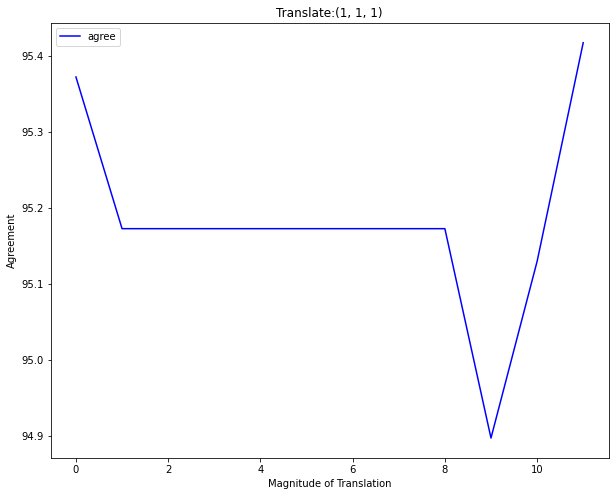

In [144]:
lf,f, xyflats, maxp_dict = eval_trans_inv_noedge_apstester(aps_tester,(1,1,1))

In [145]:
maxp_dict

{11: tensor([1]),
 10: tensor([1]),
 9: tensor([2]),
 8: tensor([1]),
 7: tensor([2]),
 6: tensor([1]),
 5: tensor([2]),
 4: tensor([1]),
 3: tensor([2]),
 2: tensor([1]),
 1: tensor([2]),
 0: tensor([1])}

tensor([0])
tensor([0])
tensor([0])
tensor([2])
tensor([0])
tensor([2])
tensor([0])
tensor([2])
tensor([0])
tensor([2])
tensor([0])
tensor([2])
tensor([2])


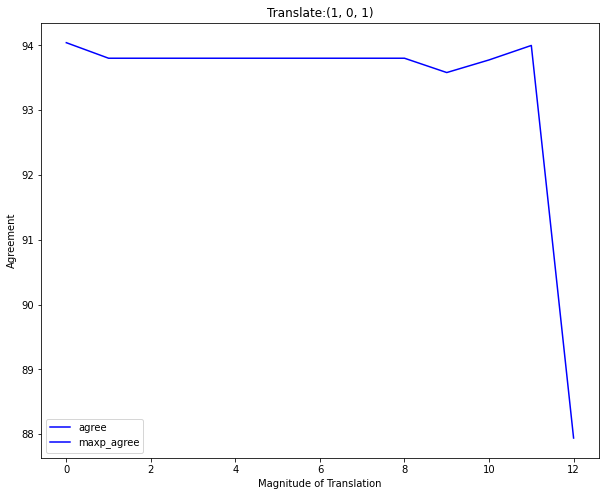

In [26]:
lf,f, xzflats = eval_trans_inv_noedge_apstester(aps_tester,(1,0,1))

tensor([0])
tensor([0])
tensor([0])
tensor([1])
tensor([0])
tensor([1])
tensor([0])
tensor([1])
tensor([0])
tensor([1])
tensor([0])
tensor([1])
tensor([1])


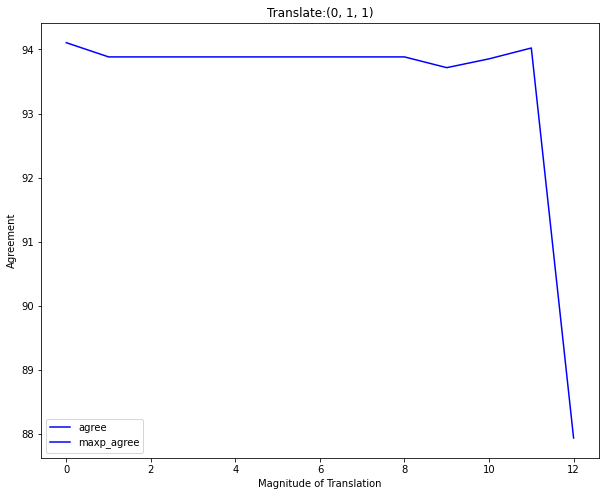

In [27]:
lf,f, yzflats = eval_trans_inv_noedge_apstester(aps_tester,(0,1,1))

tensor([0])
tensor([0])
tensor([0])
tensor([1])
tensor([0])
tensor([1])
tensor([0])
tensor([1])
tensor([0])
tensor([1])
tensor([0])
tensor([1])
tensor([1])


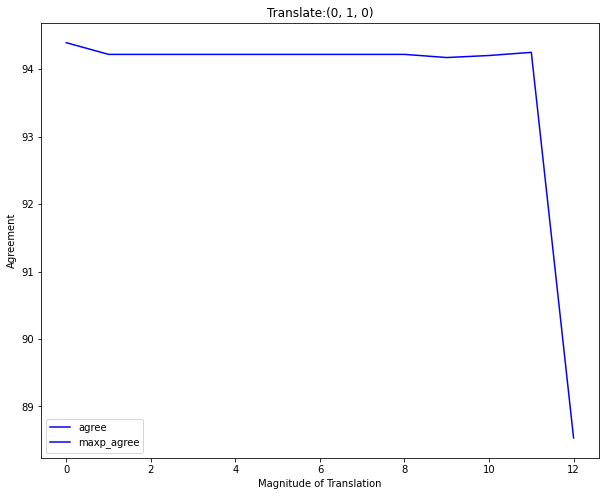

In [32]:
lf,f, yflats = eval_trans_inv_noedge_apstester(aps_tester,(0,1,0))

tensor([0])
tensor([0])
tensor([0])
tensor([2])
tensor([1])
tensor([2])
tensor([1])
tensor([2])
tensor([1])
tensor([2])
tensor([1])
tensor([2])
tensor([1])


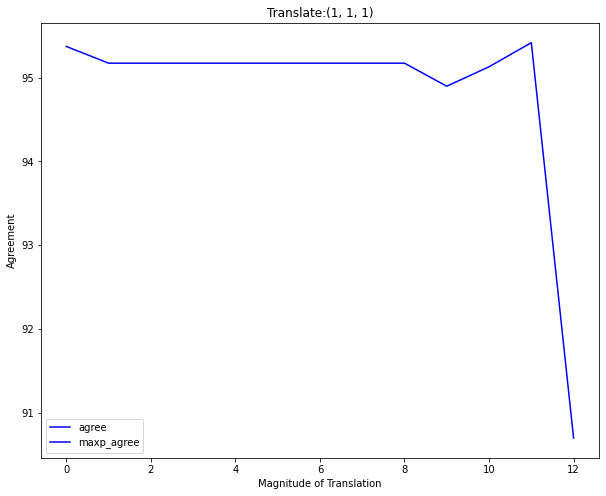

In [68]:
lf,f, xyzflats = eval_trans_inv_noedge_apstester(aps_tester,(1,1,1))

In [69]:
B,C,N,_,_ = input_tensor_1.unsqueeze(0).shape
batch_indices = torch.arange(B)

In [132]:
_ = eval_trans_inv_noedge_tester(def2018)

ValueError: not enough values to unpack (expected 3, got 2)

<Figure size 720x576 with 0 Axes>

['l2']
['l2']
['l2']
['l2']
['l2']
['l2']
['l2']
['l2']
['l2']
['l2']
['l2']
['l2']
['l2']
['l2']
['l2']
['l2']
['l2']
['l2']
['l2']
['l2']
['l2']
['l2']
['l2']
['l2']
['l2']
['l2']
['l2']
['l2']
['l2']
['l2']
['l2']
['l2']
['l2']
['l2']
['l2']
['l2']
['l2']
['l2']
['l2']
['l2']
['l2']
['l2']


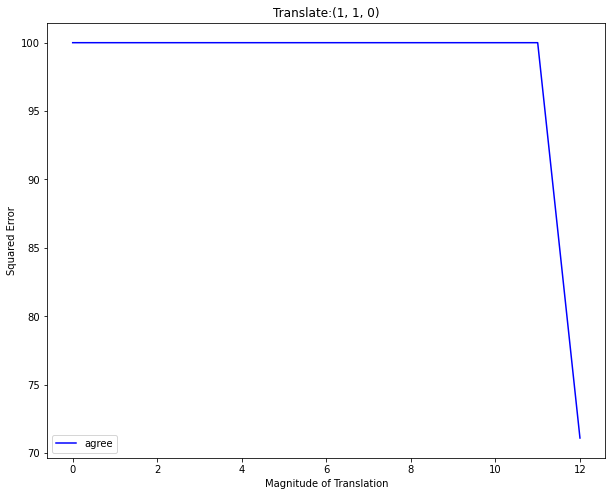

In [28]:
_ = eval_trans_inv_noedge_tester(aps_def2018)

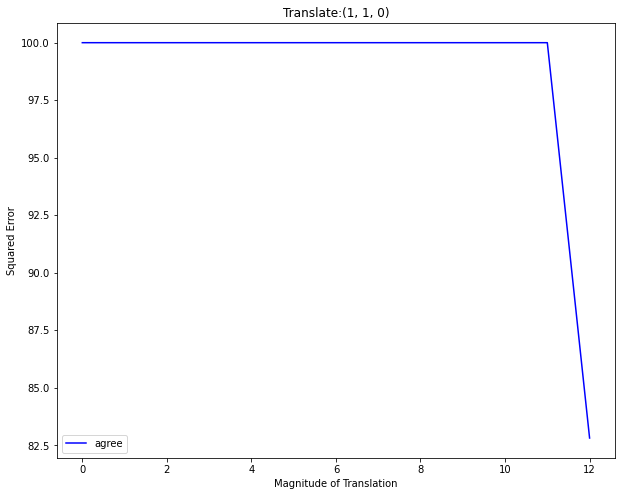

In [29]:
_ = eval_trans_inv_noedge_tester(gap_def2018)

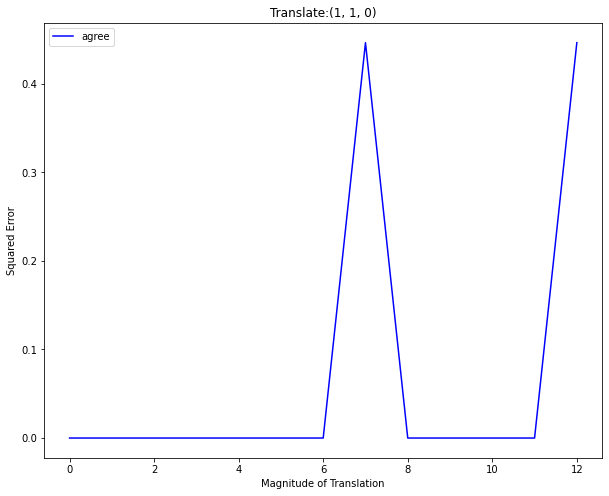

In [30]:
_,_,flats_dense = eval_trans_inv_noedge_tester(dense)

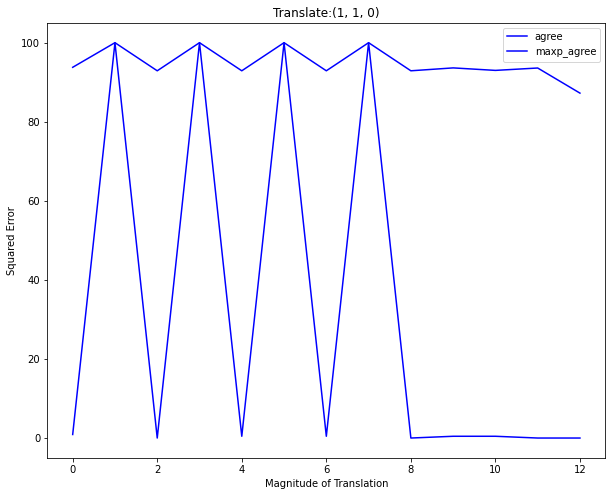

In [18]:
_, _, flats_apsdense= eval_trans_inv_noedge_tester(aps_dense)

# Look at Mag of 2d APS

In [9]:
class APSTest2d(nn.Module):
    def __init__(self, input_size, config):
        super().__init__()

        in_feats = input_size[0]

        self.first_maxp = nn.MaxPool2d(2,1)
        self.first_aps = ApsPool(in_feats,filt_size=2,apspool_criterion=config.apspool_criterion,return_poly_indices=True)

    def forward(self,x):
        x = self.first_maxp(x)
        return self.first_aps(x)

In [10]:
args.apspool_criterion = 'l2'

In [11]:
aps2d = APSTest2d((3,262,262),args).cuda()

In [12]:
import torch.utils
import torchvision.datasets as datasets
import torchvision.transforms as transforms

mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
normalize = transforms.Normalize(mean=mean, std=std)
val_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder('/home/anm329/git/truly_shift_invariant_cnns/tmp/val', transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            normalize,
        ])),
        batch_size=1, shuffle=False,
        pin_memory=True)

In [14]:
for i, (input, target) in enumerate(val_loader):
    input = input.cuda()
    print(input.shape)
    ouput =aps2d(input)

    #compute output for shifted inputs

    shift0 = np.random.randint(-32, 32, size=2)
    shift1 = np.random.randint(-32, 32, size=2)

    shifted_inp0 = torch.roll(input, shifts = (shift0[0], shift0[1]) , dims = (2, 3) )
    shifted_inp1 = torch.roll(input, shifts = (shift1[0], shift1[1]) , dims = (2, 3) )

    output_shifted_inp0 = model(shifted_inp0)
    output_shifted_inp1 = model(shifted_inp1)

torch.Size([1, 3, 224, 224])


RuntimeError: shape '[1, 3, 112, 112]' is invalid for input of size 150528

In [169]:
args

Namespace(apspool_criterion='l2', dropout=0, hidden_size=0)